In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os

In [ ]:
!pip install torch torchvision

In [ ]:
from PIL import Image

# Load an example image from your dataset
image_path = '/content/gdrive/My Drive/nndlprojectdata/pRCC/train/3610_6089_2000.jpg'
img = Image.open(image_path)

# Get the dimensions of the image
width, height = img.size
print(f"Image dimensions: {width} x {height}")

Image dimensions: 2000 x 2000


**Loading the dataset**

In [ ]:
# Set the paths to your data
root_dir = '/content/drive/My Drive/nndl/dataset/pRCC_nolabel_original_and_augmented/pRCC_nolabel_original_and_augmented'
#val_dir = '/content/drive/My Drive/nndlprojectdata/pRCC/validation'
input_shape = (3, 2000, 2000)  # Channels, Height, Width


# Create a custom dataset and data loader for unlabeled data (without classes)
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_files = os.listdir(data_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_dir, self.image_files[idx])
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        return image

# Define the transform to preprocess the images
transform = transforms.Compose([
    transforms.Resize((700, 700)),
    transforms.ToTensor(),
])

# Create your custom dataset
custom_dataset = CustomDataset(root_dir, transform=transform)

# Create a DataLoader to efficiently load the data
batch_size = 2  # You can adjust this based on your system's memory
dataloader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)

# The DataLoader is now set up to load your dataset of unlabeled images.
dataset_length = len(dataloader.dataset)
print("Length of the dataset:", dataset_length)



from torch.utils.data.dataset import random_split

dataset_size = dataset_length
train_size = int(0.7 * dataset_size)  # 70% for training
test_size = int(0.15 * dataset_size)  # 15% for testing
val_size = dataset_size - train_size - test_size  # The rest for validation

# Use random_split to create datasets
train_dataset, test_dataset, val_dataset = random_split(custom_dataset, [train_size, test_size, val_size])

# Create DataLoaders for each set
batch_size = 2  # Adjust as needed
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

Length of the dataset: 2838


**Defining the class for the autoencoder**

In [ ]:
# Define a custom autoencoder class
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
# Create the autoencoder model and move it to the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
autoencoder = Autoencoder()
autoencoder.to(device)

# Loss function and optimizer
batch_size = 2
num_epochs = 20
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

**Model Training**

In [ ]:

# Check for GPU availability and set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

epoch_wise_training_loss = []
epoch_wise_validation_loss = []
# Training loop
for epoch in range(num_epochs):
    print("============started epoch============: ", epoch)
    running_loss = 0.0
    autoencoder.train()
    batch_count =0
    for i, data in enumerate(train_dataloader, 0):
        batch_count +=1
        #print("processing batch: ", batch_count)
        data = data.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = autoencoder(data)
        loss = criterion(outputs, data)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print("training done, starting val for this epoch")
    autoencoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(val_dataloader, 0):
            data = data.to(device)  # Move data to GPU
            outputs = autoencoder(data)
            loss = criterion(outputs, data)
            val_loss += loss.item()

    print(f'Epoch {epoch + 1}: Training Loss = {running_loss / len(train_dataloader)}, Validation Loss = {val_loss / len(val_dataloader)}')
    epoch_wise_training_loss.append(running_loss / len(train_dataloader))
    epoch_wise_validation_loss.append(val_loss / len(val_dataloader))

print('Completed')


============started epoch============:  0
training done, starting val for this epoch
Epoch 1: Training Loss = 0.0033232050216058036, Validation Loss = 0.0025804736036763778
============started epoch============:  1
training done, starting val for this epoch
Epoch 2: Training Loss = 0.0025104945790480303, Validation Loss = 0.0022478807074557466
============started epoch============:  2
training done, starting val for this epoch
Epoch 3: Training Loss = 0.002140454439496038, Validation Loss = 0.002190522225051422
============started epoch============:  3
training done, starting val for this epoch
Epoch 4: Training Loss = 0.0019218133780533168, Validation Loss = 0.0017107346301319549
============started epoch============:  4
training done, starting val for this epoch
Epoch 5: Training Loss = 0.0018956616084998303, Validation Loss = 0.0017179298093847094
============started epoch============:  5
training done, starting val for this epoch
Epoch 6: Training Loss = 0.001665870924416952, Valid

In [ ]:
torch.save(autoencoder.state_dict(), 'my_pRCC_autoencoder.pth')
print('saved model')

saved model


In [ ]:
print(epoch_wise_training_loss)

[0.0033232050216058036, 0.0025104945790480303, 0.002140454439496038, 0.0019218133780533168, 0.0018956616084998303, 0.001665870924416952, 0.0016771630679579847, 0.0016138686708592944, 0.0015756154825281603, 0.0014979148595214025, 0.0014723462309331463, 0.0014619445224261626, 0.0013976087973078888, 0.0013938503722544884, 0.0013383038579460518, 0.0013346789646373211, 0.001319549085086067, 0.0012823705460518892, 0.0012445674977858044, 0.0012835266289215868]


In [ ]:
print(epoch_wise_validation_loss)

[0.0025804736036763778, 0.0022478807074557466, 0.002190522225051422, 0.0017107346301319549, 0.0017179298093847094, 0.0015210310782188393, 0.0017280526593584289, 0.0014370115126796485, 0.001536964089881681, 0.001375065884709567, 0.0015737345952444894, 0.0017824447196995335, 0.0012512961907092499, 0.0012484258565742732, 0.001239586861425506, 0.0012176421240557456, 0.0011690278098565987, 0.0012283847611789182, 0.0012694847232566399, 0.0011651495956569893]


In [ ]:
torch.save(autoencoder.state_dict(), '/content/drive/My Drive/nndlprojectdata/pRCC/autoencoder_model.pth')

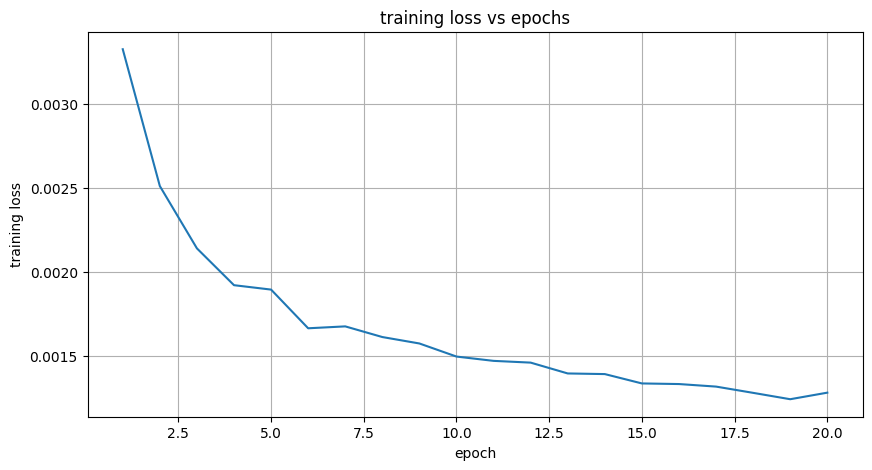

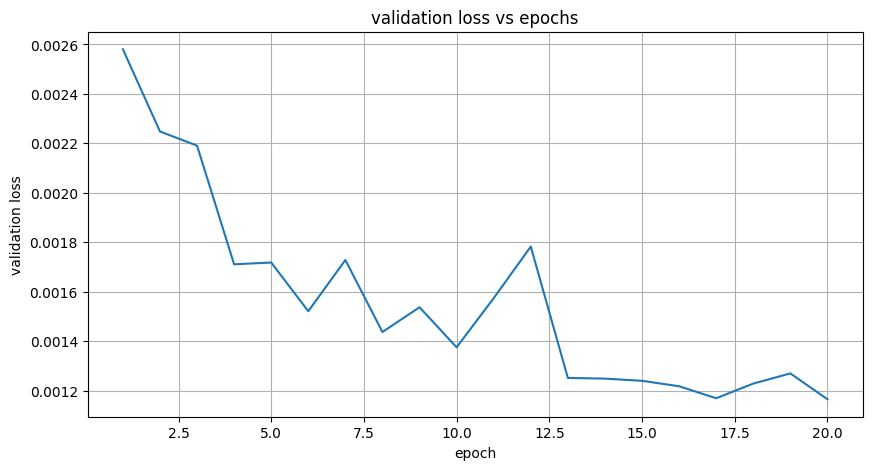

In [ ]:
import matplotlib.pyplot as plt


training_loss = [0.0033232050216058036, 0.0025104945790480303, 0.002140454439496038, 0.0019218133780533168, 0.0018956616084998303, 0.001665870924416952, 0.0016771630679579847, 0.0016138686708592944, 0.0015756154825281603, 0.0014979148595214025, 0.0014723462309331463, 0.0014619445224261626, 0.0013976087973078888, 0.0013938503722544884, 0.0013383038579460518, 0.0013346789646373211, 0.001319549085086067, 0.0012823705460518892, 0.0012445674977858044, 0.0012835266289215868]

validation_loss = [0.0025804736036763778, 0.0022478807074557466, 0.002190522225051422, 0.0017107346301319549, 0.0017179298093847094, 0.0015210310782188393, 0.0017280526593584289, 0.0014370115126796485, 0.001536964089881681, 0.001375065884709567, 0.0015737345952444894, 0.0017824447196995335, 0.0012512961907092499, 0.0012484258565742732, 0.001239586861425506, 0.0012176421240557456, 0.0011690278098565987, 0.0012283847611789182, 0.0012694847232566399, 0.0011651495956569893]


epochs = range(1, 21)

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_loss, label='training loss')
plt.title('training loss vs epochs')
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.grid(True)

plt.show()

# Plot the validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, validation_loss, label='validation loss')
plt.title('validation loss vs epochs')
plt.xlabel('epoch')
plt.ylabel('validation loss')
plt.grid(True)

plt.show()


In [ ]:
torch.save(autoencoder.state_dict(), '/content/drive/My Drive/mypRCC_autoencoder_128_64_20ep.pth')

**Loading Model and checking reconstruction**

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# Load the trained autoencoder model
autoencoder = Autoencoder()
autoencoder.load_state_dict(torch.load('/content/drive/My Drive/mypRCC_autoencoder_128_64_20ep.pth'))
autoencoder.eval()

input_image_path = '/content/drive/My Drive/nndl/dataset/pRCC_nolabel_original_and_augmented/pRCC_nolabel_original_and_augmented/100563_19024_2000.jpg'
input_image = Image.open(input_image_path)

transform = transforms.Compose([transforms.Resize((700, 700)), transforms.ToTensor()])

input_tensor = transform(input_image).unsqueeze(0)
output_tensor = autoencoder(input_tensor)
reconstructed_image = output_tensor.squeeze(0).detach().cpu().numpy()
reconstructed_image = (reconstructed_image * 255).astype('uint8')
reconstructed_image = Image.fromarray(reconstructed_image.transpose(1, 2, 0), 'RGB')
reconstructed_image.show()


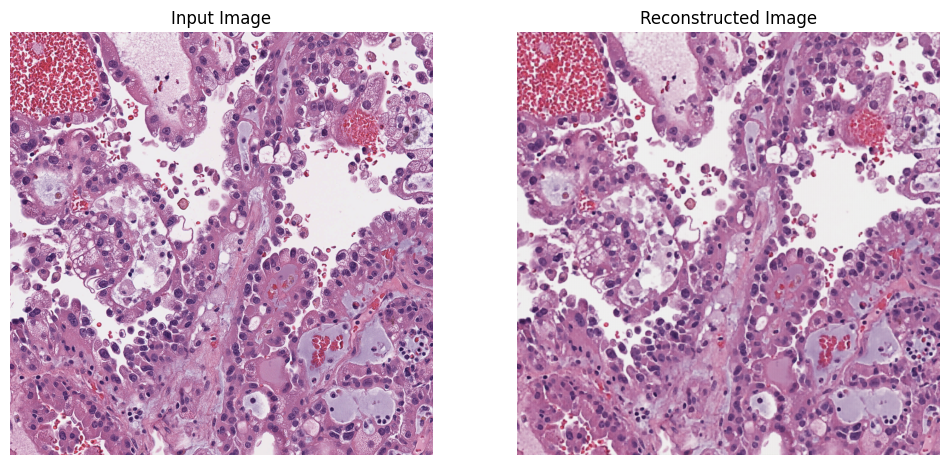

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title('Input Image')
axes[0].imshow(input_image)
axes[0].axis('off')
axes[1].set_title('Reconstructed Image')
axes[1].imshow(reconstructed_image)
axes[1].axis('off')
plt.show()